In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score,accuracy_score,recall_score,f1_score,accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import folium
import re

In [2]:
try:
    df=pd.read_csv("C:/Users/Administrator/Downloads/Dataset .csv")
    print('File loaded successfully')

except FileNotFoundError:
    print(
        "Error: 'Dataset.csv' not found. Please ensure the CSV file is in the same directory.")
    exit()

File loaded successfully


In [3]:
df

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9546,5915730,Naml۱ Gurme,208,��stanbul,"Kemanke�� Karamustafa Pa��a Mahallesi, R۱ht۱m ...",Karak�_y,"Karak�_y, ��stanbul",28.977392,41.022793,Turkish,...,Turkish Lira(TL),No,No,No,No,3,4.1,Green,Very Good,788
9547,5908749,Ceviz A��ac۱,208,��stanbul,"Ko��uyolu Mahallesi, Muhittin ��st�_nda�� Cadd...",Ko��uyolu,"Ko��uyolu, ��stanbul",29.041297,41.009847,"World Cuisine, Patisserie, Cafe",...,Turkish Lira(TL),No,No,No,No,3,4.2,Green,Very Good,1034
9548,5915807,Huqqa,208,��stanbul,"Kuru�_e��me Mahallesi, Muallim Naci Caddesi, N...",Kuru�_e��me,"Kuru�_e��me, ��stanbul",29.034640,41.055817,"Italian, World Cuisine",...,Turkish Lira(TL),No,No,No,No,4,3.7,Yellow,Good,661
9549,5916112,A���k Kahve,208,��stanbul,"Kuru�_e��me Mahallesi, Muallim Naci Caddesi, N...",Kuru�_e��me,"Kuru�_e��me, ��stanbul",29.036019,41.057979,Restaurant Cafe,...,Turkish Lira(TL),No,No,No,No,4,4.0,Green,Very Good,901


In [4]:
df['Price range'].isnull().sum()

0

In [5]:
print("\n--- Task 3: Cuisine Classification ---")

mode=df['Cuisines'].mode()
df['Cuisines']=df['Cuisines'].fillna(mode[0])

text_features=['Cuisines','Restaurant Name','City','Address','Locality','Locality Verbose']
for col in text_features:
    df[col]=df[col].astype(str).apply(lambda x : re.sub(r'[^a-zA-Z\s]','',x).lower())

df['Price range']=df['Price range'].astype(str)
df['Votes']=df['Votes'].astype(str)

s=df['Cuisines'].str.split(',').apply(pd.Series, 1).stack()
s.index=s.index.droplevel(-1)
s.name='Cuisine'

df_cuisine=df.drop('Cuisines',axis=1).join(s)

df_cuisine['Cuisine']=df_cuisine['Cuisine'].str.strip().str.lower()

df_cuisine=df_cuisine[~df_cuisine['Cuisine'].isin(['unknown','','nan'])]

cuisine_counts=df_cuisine['Cuisine'].value_counts()
rare_cuisines=cuisine_counts[cuisine_counts<50].index
df_cuisine=df_cuisine[~df_cuisine['Cuisine'].isin(rare_cuisines)]

if df_cuisine.empty or len(df_cuisine['Cuisine'].unique())<2:
    print("Not enough data for cuisine classification after filtering. Need at least 2 unique cuisines with enough samples.")
else:
    label_encoder=LabelEncoder()
    df_cuisine['Enc_Cuisine']=label_encoder.fit_transform(df_cuisine['Cuisine'])

    df_cuisine['Text_Features'] = df_cuisine['Restaurant Name'].fillna('') + " " + \
                                  df_cuisine['Locality'].fillna('') + " " + \
                                  df_cuisine['City'].fillna('') + " "  + \
                                  df_cuisine['Locality Verbose'].fillna('') + " " + \
                                  df_cuisine['Address'].fillna('') + " " + \
                                  df_cuisine['Price range'].fillna('') + " " + \
                                  df_cuisine['Votes'].fillna('')
    

    tfidf_vectorizer=TfidfVectorizer(stop_words='english',max_features=1000,ngram_range=(1,2))
    tfidf_matrix=tfidf_vectorizer.fit_transform(df_cuisine['Text_Features'])

    X=tfidf_matrix
    y=df_cuisine['Enc_Cuisine']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models={
    'Logistic Regression':LogisticRegression(max_iter=1000,C=1.0),
    'Random Forest Classifier':RandomForestClassifier(n_estimators=200,max_depth=20,random_state=42)
    }

    for name,model in models.items():
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        print(f'\n -- Training {name} for Cuisine Classification -- ')

        print('\n')

        print(f'\n --- {name} Performance Evaluation --- ')

        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision (macro): {precision_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
        print(f"  Recall (macro): {recall_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
        print(f"  F1-Score (macro): {f1_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
        print(f"\nClassification Report:\n{classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0)}")

    print("Cuisine classification task complete.")


--- Task 3: Cuisine Classification ---


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10720\2274205597.py:13: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  s=df['Cuisines'].str.split(',').apply(pd.Series, 1).stack()



 -- Training Logistic Regression for Cuisine Classification -- 



 --- Logistic Regression Performance Evaluation --- 
  Accuracy: 0.2597
  Precision (macro): 0.1492
  Recall (macro): 0.0922
  F1-Score (macro): 0.0881

Classification Report:
                                       precision    recall  f1-score   support

american fast food salad healthy food       0.00      0.00      0.00        12
                               bakery       0.25      0.09      0.13        44
                      bakery desserts       0.05      0.04      0.04        28
            bakery desserts fast food       0.00      0.00      0.00        13
                     bakery fast food       0.00      0.00      0.00        24
                            beverages       0.00      0.00      0.00        14
                              biryani       0.00      0.00      0.00         8
                                 cafe       0.43      0.46      0.44        70
                              chinese       

In [6]:
from scipy.sparse import hstack,csc_matrix

In [7]:
text_feat=['Cuisines', 'Restaurant Name', 'City', 'Address', 'Locality', 'Locality Verbose']
for col in text_feat:
    df[col]=df[col].astype(str).apply(lambda x : re.sub(r'[^a-zA-Z\s]','',x).lower())

df['Price range']=pd.to_numeric(df['Price range'], errors='coerce')


s=df['Cuisines'].str.split(',').apply(pd.Series,1).stack()
s.index=s.index.droplevel(-1)
s.name='Cuisinee'

df_cuisine=df.drop('Cuisines',axis=1).join(s)

df_cuisine['Cuisinee']=df_cuisine['Cuisinee'].str.strip().str.lower()

df_cuisine=df_cuisine[~df_cuisine['Cuisinee'].isin(['unknown','','nan'])]

top_n=5
top_cuisines=df_cuisine['Cuisinee'].value_counts().nlargest(top_n).index
df_cuisine=df_cuisine[df_cuisine['Cuisinee'].isin(top_cuisines)]

label_encoder=LabelEncoder()
df_cuisine['Cuisine_Enc']=label_encoder.fit_transform(df_cuisine['Cuisinee'])

df_cuisine['Text_Features'] = df_cuisine['Restaurant Name'].fillna('') + " " + \
                              df_cuisine['Locality'].fillna('') + " " + \
                              df_cuisine['City'].fillna('') + " " + \
                              df_cuisine['Locality Verbose'].fillna('') + " " + \
                              df_cuisine['Address'].fillna('')

tfidf_vect=TfidfVectorizer(
    stop_words='english',
    max_features=2000,
    ngram_range=(1,3),
    min_df=5
)

tfidf_mat=tfidf_vect.fit_transform(df_cuisine['Text_Features'])

df_cuisine['Price range']=pd.to_numeric(df_cuisine['Price range'],errors='coerce')
df_cuisine['Votes']=pd.to_numeric(df_cuisine['Votes'],errors='coerce')

df_cuisine[['Price range','Votes']]=df_cuisine[['Price range','Votes']].fillna(0)

X_num=csc_matrix(df_cuisine[['Price range','Votes']].values)
X=hstack([tfidf_mat,X_num])
y=df_cuisine['Cuisine_Enc']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models={
    'RandomForestClassifier':RandomForestClassifier(n_estimators=300,max_depth=25,random_state=42),
    'GradientBoostingClassifier':GradientBoostingClassifier(random_state=42)
}

for name, model in models.items():
    print(f'\n -- Training {name} for Cuisine Classification -- ')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n --- {name} Performance Evaluation --- ")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"  Precision (macro): {precision_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
    print(f"  Recall (macro): {recall_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
    print(f"  F1-Score (macro): {f1_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
    print(f"\nClassification Report:\n{classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0)}")

print("✅ Cuisine classification task complete.")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10720\4161510731.py:8: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  s=df['Cuisines'].str.split(',').apply(pd.Series,1).stack()



 -- Training RandomForestClassifier for Cuisine Classification -- 

 --- RandomForestClassifier Performance Evaluation --- 
  Accuracy: 0.5540
  Precision (macro): 0.6617
  Recall (macro): 0.4524
  F1-Score (macro): 0.4873

Classification Report:
                      precision    recall  f1-score   support

             chinese       0.90      0.49      0.64        71
           fast food       0.85      0.24      0.37        71
        north indian       0.51      0.89      0.65       189
north indian chinese       0.50      0.40      0.45       102
north indian mughlai       0.55      0.24      0.33        67

            accuracy                           0.55       500
           macro avg       0.66      0.45      0.49       500
        weighted avg       0.62      0.55      0.52       500


 -- Training GradientBoostingClassifier for Cuisine Classification -- 

 --- GradientBoostingClassifier Performance Evaluation --- 
  Accuracy: 0.5660
  Precision (macro): 0.5969
  Recall (m

In [8]:
df['Price range'].unique()

array([3, 4, 2, 1], dtype=int64)

In [9]:
print("\n--- Task 4: Location-based Analysis ---")
print('\n')
df_location=df.dropna(subset=['Latitude','Longitude']).copy()
df_location['Latitude']=pd.to_numeric(df_location['Latitude'],errors='coerce')
df_location['Longitude']=pd.to_numeric(df_location['Longitude'],errors='coerce')

if df_location.empty:
    print("No valid latitude/longitude data for location analysis after cleaning.")

else:
    print("Generating restaurant distribution map... (This might take a moment for large datasets)")
    
    map_center=[df_location['Latitude'].mean(),
               df_location['Longitude'].mean()]
    restaurant_map=folium.Map(location=map_center,
                             zoom_start=5)

    for idx,row in df_location.iterrows():
        folium.Marker(
            location=[row['Latitude'],row['Longitude']],
            popup=f"<b>{row['Restaurant Name']}</b><br>Cuisines: :{row['Cuisines']}<br>Rating :{row['Aggregate rating']}<br>City :{row['City']}"
        ).add_to(restaurant_map)

    map_file="index.html"
    restaurant_map.save(map_file)
    print(f"Restaurant distribution map saved to {map_file}. Open this HTML file in a web browser to view the map.")


--- Task 4: Location-based Analysis ---


Generating restaurant distribution map... (This might take a moment for large datasets)
Restaurant distribution map saved to index.html. Open this HTML file in a web browser to view the map.


In [10]:
print("\nAnalyzing restaurant concentration by City...")
city_counts=df_location['City'].value_counts().reset_index()
city_counts.columns=['City','Restaurant_Count']
print('\n') 
print("Top 10 Cities by Restaurant Count:")
print(city_counts.head(10))


Analyzing restaurant concentration by City...


Top 10 Cities by Restaurant Count:
           City  Restaurant_Count
0     new delhi              5473
1       gurgaon              1118
2         noida              1080
3     faridabad               251
4     ghaziabad                25
5  bhubaneshwar                21
6      amritsar                21
7     ahmedabad                21
8       lucknow                21
9      guwahati                21


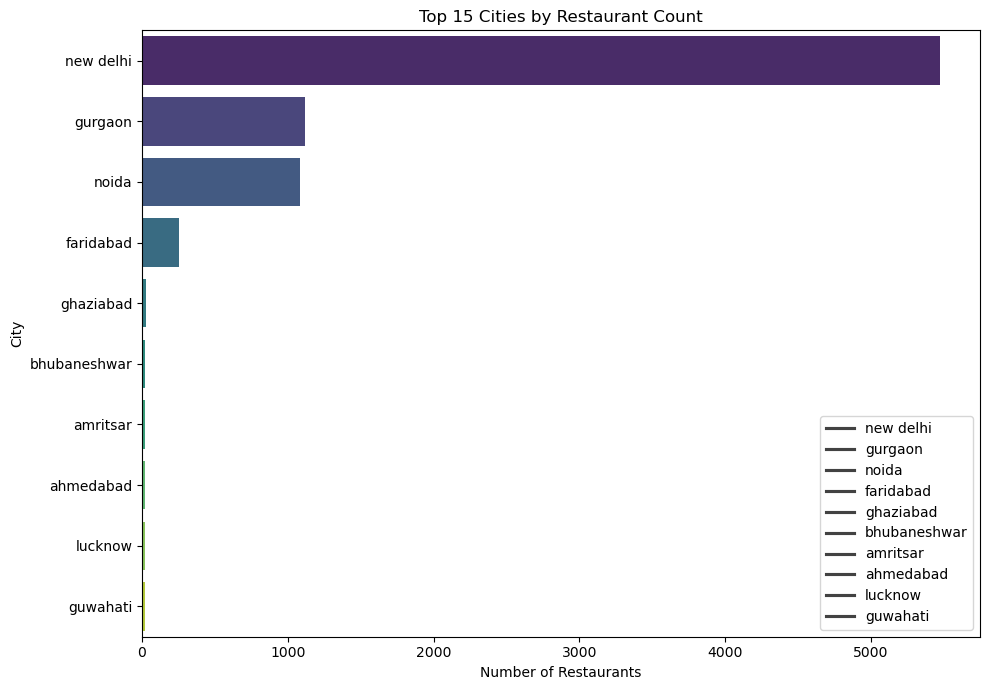

In [11]:
plt.figure(figsize=(10,7))
sns.barplot(x='Restaurant_Count',y='City',
           hue='City',data=city_counts.head(10),
            palette='viridis')
plt.title('Top 15 Cities by Restaurant Count')
plt.xlabel('Number of Restaurants')
plt.ylabel('City')
plt.tight_layout()
plt.legend(labels=city_counts['City'].head(10),loc='lower right')
plt.show()

In [12]:
df['Price range']=pd.to_numeric(df['Price range'], errors='coerce')

In [13]:
df['Price range'].value_counts(dropna=False)

Price range
1    4444
2    3113
3    1408
4     586
Name: count, dtype: int64

In [14]:
import numpy as np

In [15]:
print("\nCalculating average ratings, price range by City...")
df_location['Price range'] = df_location['Price range'].replace(['-', '', 'unknown', 'N/A'], np.nan)

df_location['Price range'] = pd.to_numeric(df_location['Price range'], errors='coerce')
df_location['Aggregate rating'] = pd.to_numeric(df_location['Aggregate rating'], errors='coerce')

#df_location = df_location.dropna(subset=['Price range', 'Aggregate rating'])

stats_1=df_location.groupby('City').agg(
    Average_Rating=('Aggregate rating','mean'),
    Average_Price_Range=('Price range','mean'),
    Rest_Count=('Restaurant Name','count')
).sort_values(by='Rest_Count',ascending=False)

print("City Statistics (Top 5 by restaurant count):")
print('\n')
print(stats_1.head())


Calculating average ratings, price range by City...
City Statistics (Top 5 by restaurant count):


           Average_Rating  Average_Price_Range  Rest_Count
City                                                      
new delhi        2.438845             1.621597        5473
gurgaon          2.651431             1.855993        1118
noida            2.036204             1.601852        1080
faridabad        1.866932             1.454183         251
ghaziabad        2.852000             1.800000          25


In [16]:
print("\nCalculating average ratings, price range by Latitude...")

stats_2=df_location.groupby('Latitude').agg(
    Average_Rating=('Aggregate rating','mean'),
    Average_Price_Range=('Price range','mean'),
    Rest_Count=('Restaurant Name','count')
).sort_values(by='Rest_Count',ascending=False)

print("Latitude Statistics (Top 5 by restaurant count):")
print('\n')
print(stats_2.head())


Calculating average ratings, price range by Latitude...
Latitude Statistics (Top 5 by restaurant count):


           Average_Rating  Average_Price_Range  Rest_Count
Latitude                                                  
0.000000         1.506225             1.588353         498
28.574309        2.143750             1.500000          16
28.551456        3.300000             2.000000           9
28.574300        1.988889             1.444444           9
28.597103        2.200000             1.625000           8


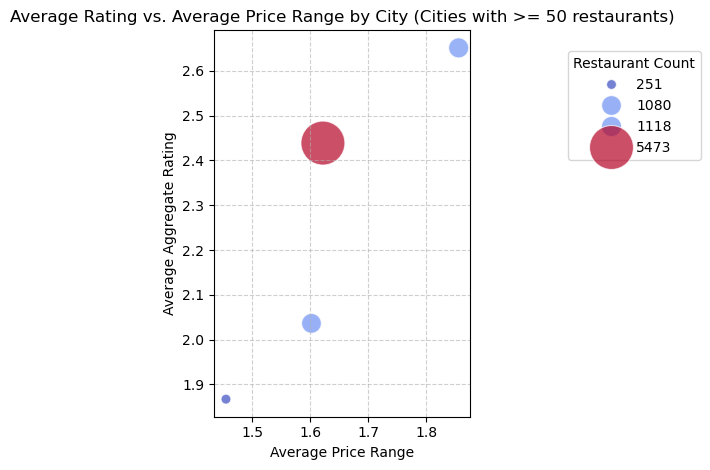


Location-based analysis complete. Examine the generated map and plots for insights.


In [17]:
min_restaurants=50

plot_stats_1=stats_1[stats_1['Rest_Count']>=min_restaurants].copy()

if not plot_stats_1.empty:
    sns.scatterplot(
            x='Average_Price_Range',
            y='Average_Rating',
            size='Rest_Count',
            hue='Rest_Count',
            data=plot_stats_1,
            sizes=(50, 1000), # Adjust size range for bubbles
            palette='coolwarm',
            alpha=0.7
        )
    
    plt.title(f'Average Rating vs. Average Price Range by City (Cities with >= {min_restaurants} restaurants)')
    plt.xlabel('Average Price Range')
    plt.ylabel('Average Aggregate Rating')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Restaurant Count', 
               bbox_to_anchor=(1.3, 1), 
               loc='upper left',
               borderaxespad=1.5,
               frameon=True
              )
    plt.tight_layout()
    plt.show()

else:
    print(f"\nNot enough cities with >= {min_restaurants} restaurants to generate detailed scatter plot.")

print("\nLocation-based analysis complete. Examine the generated map and plots for insights.")

In [18]:
plot_stats_1

,Average_Rating,Average_Price_Range,Rest_Count
City,,,
new delhi,2.438845,1.621597,5473
gurgaon,2.651431,1.855993,1118
noida,2.036204,1.601852,1080
faridabad,1.866932,1.454183,251
